In [1]:
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import solve_ivp
from scipy.signal import convolve
from tqdm import tqdm

# Discrete Stochastic Mountain Car

a: -2, force: -0.9640275800758169
a: -1, force: -0.7615941559557649
a: 0, force: 0.0
a: 1, force: 0.7615941559557649
a: 2, force: 0.9640275800758169


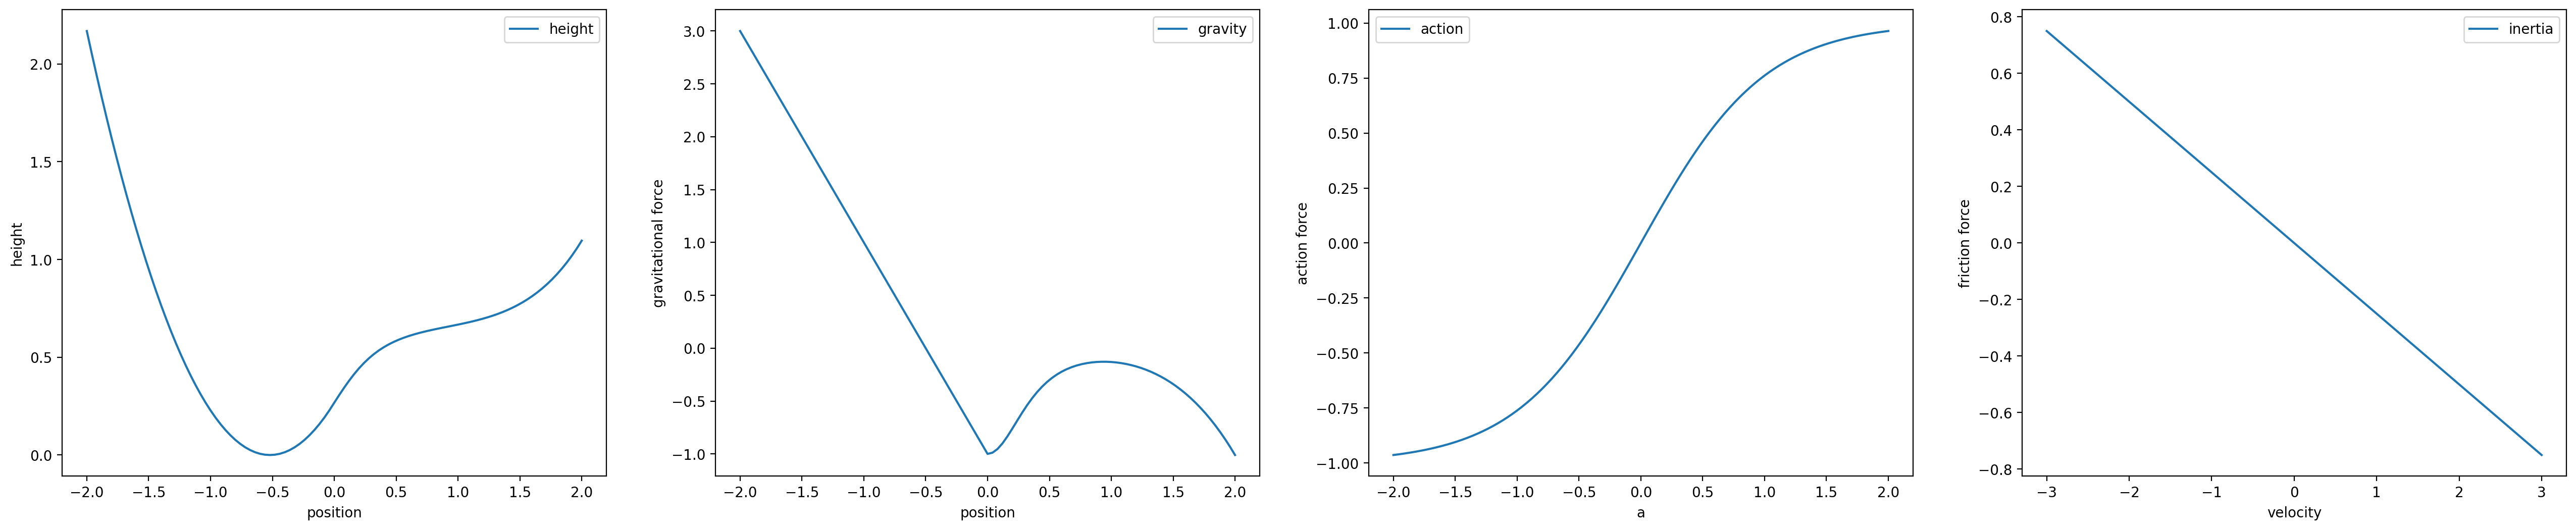

In [2]:
N = 101
x = np.linspace(-2,2, 101)
v = np.linspace(-3,3, 101)

f_action = lambda a: np.tanh(a)

for x in [-2, -1, 0, 1, 2]:
    print(f'a: {x}, force: {f_action(x)}')

def f_gravity(x):
    phi = np.zeros_like(x)
    is_leq0 = x<=0
    phi_1 = 2*x+1
    a = (1 + 5*x**2)
    phi_2 = a**(-0.5)
    phi_3 = - 5*x**2*a**(-1.5)
    phi_4 = (x/2)**4 # negative of paper
    phi = phi_2 + phi_3 + phi_4
    phi[is_leq0] = phi_1[is_leq0]  
    return -phi

N = 101
w = 4/N
x = np.linspace(-2,2,N)
g = f_gravity(x)
h = np.cumsum(-g)*w
h -= h.min()

def height(state):
  pos = np.clip(state[0], x[0], x[-1])
  r = x[-1] - x[0] + 1e-6
  i_x = int((pos-x[0])/r * N)
  #print(pos, r, i_x, h[i_x])
  return h[i_x]

def f_friction(v):
    return -1/4*v

def f(t, s, a):
  dx = s[1]
  f_a = f_action(a)
  f_g = f_gravity(s[0])
  f_i = f_friction(s[1])
  dv = f_a + f_g + f_i 
  #print(f't {t:.2f}, s {s[0,0]:.2f}, {s[1,0]:.2f}, a {a:.2f}, fa {f_a:.2f}, fg {f_g[0]:.2f}, fi {f_i[0]:.2f}')
  return np.array([dx, dv])

xx = np.linspace(-2, 2, 32)
vv = np.linspace(-3, 3, 32)

fig, ax = plt.subplots(1, 4, figsize=(4*8, 6))
plt.sca(ax[0])
plt.plot(x,h, label='height')
plt.xlabel('position')
plt.ylabel('height')
plt.legend()

plt.sca(ax[1])
plt.plot(x, g, label='gravity')
plt.xlabel('position')
plt.ylabel('gravitational force')
plt.legend()

plt.sca(ax[2])
aa = np.linspace(-2, 2, 101)
plt.plot(aa, f_action(aa), label='action')
plt.xlabel('a')
plt.ylabel('action force')
plt.legend()

plt.sca(ax[3])
plt.plot(v, f_friction(v), label='inertia')
plt.xlabel('velocity')
plt.ylabel('friction force')
plt.legend()


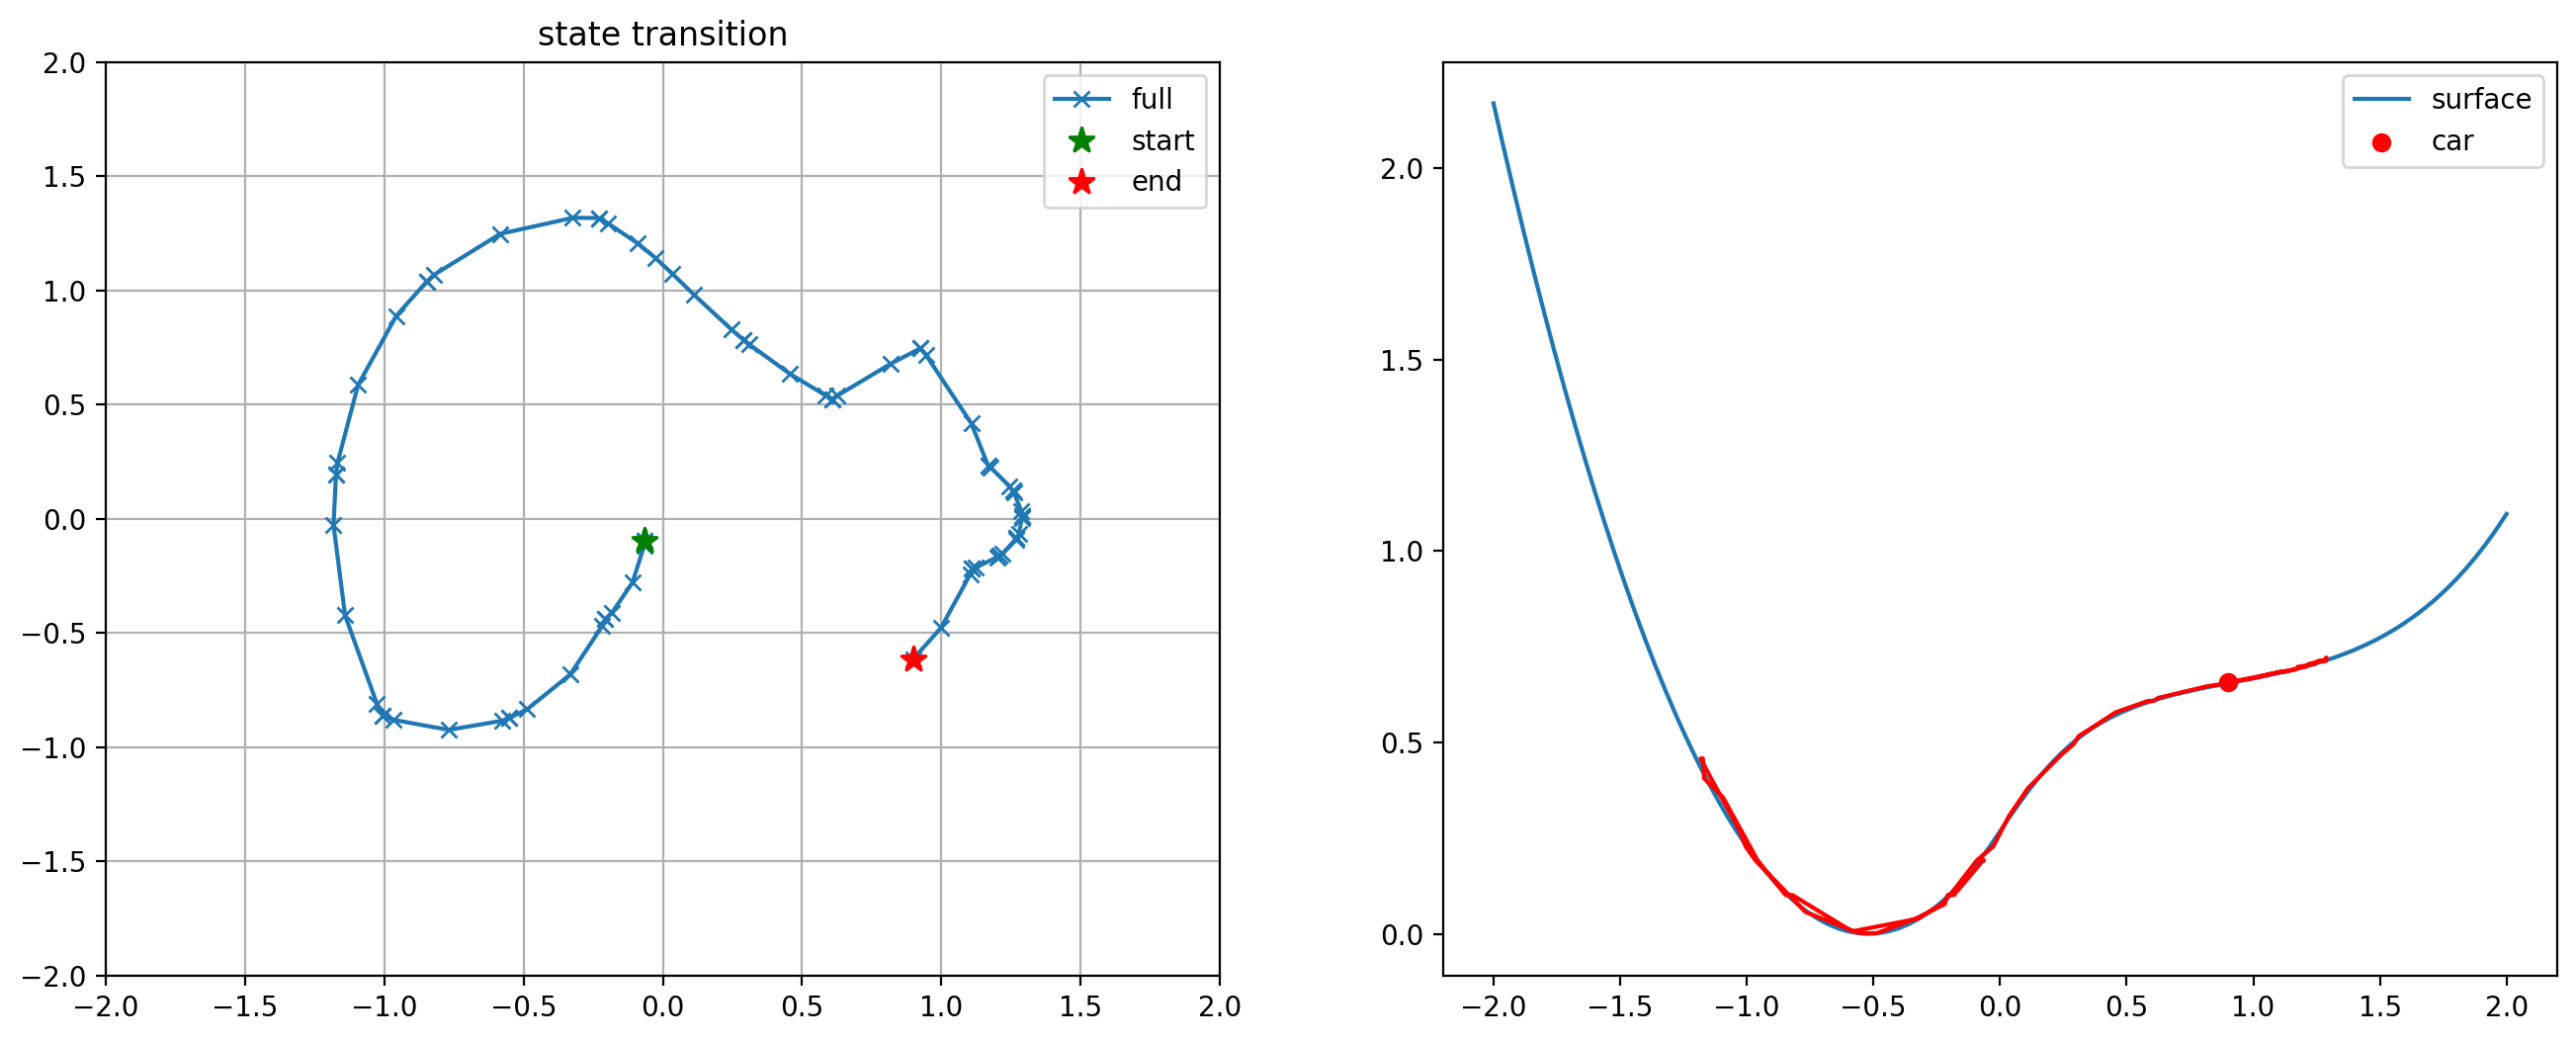

In [3]:
def s1_given_s_a(s, a, debug=False, use_ivp=True):
  if use_ivp:
    sol = solve_ivp(f, t_span=[0.0, 0.5], y0=s, rtol=1e-6, vectorized=True, args=(a,)) # Fig 5: [0, 0.5] with zero action start
  else:
    dt = 0.6
    ds = f(None, np.array(s)[:,np.newaxis], a)
    sol = namedtuple('sol', 'y')
    sol.y = (np.array(s)+ds.squeeze()*dt).reshape((-1,1))
    
  if debug:
    return sol

  return sol.y[:,-1]

s0 = [-0.06451613, -0.09677419]
aa_fig4 = [4, 4, 3, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 1, 2] 
        #, 4, 4, 3, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 1, 2]
aa_fig5 = [2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1] #[2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1]

aa = aa_fig5
a = [-2, -1, 0, 1, 2]
aa = [a[x] for x in aa]

ss = [s0]
ss_full = [s0]
for a in aa:
  sol = s1_given_s_a(s=ss[-1], a=a, debug=True)
  ss.append(sol.y[:,-1])
  ss_full.extend(sol.y.T.tolist())

def plot_trajectory(states, ax=None, color=None, alpha=1, label=None, legend=True):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(2*10, 5))
  
  xx = [s[0] for s in states]
  vv = [s[1] for s in states]
  hh = np.array([height(s) for s in states])
  hh += np.linspace(0, 1, hh.shape[0]) * 0.00
  
  plt.sca(ax[0])
  plt.plot(xx, vv, 'x-', label=label, color=color, alpha=alpha)
  plt.plot([xx[0]], [vv[0]], 'g*', ms=10, label='start')
  plt.plot([xx[-1]], [vv[-1]], 'r*', ms=10, label='end')
  plt.xlim([-2,2])
  plt.ylim([-2,2])
  plt.title('state transition')
  plt.grid('on')
  if legend:
    plt.legend()
  
  plt.sca(ax[1])
  plt.plot(x,h, label='surface')
  plt.plot(xx, hh, 'r-')
  plt.scatter([xx[-1]], [hh[-1]], color='red', marker='o', label='car')
  if legend:
    plt.legend()
  
fig, ax = plt.subplots(1, 2, figsize=(2*8, 6))
plot_trajectory(ss_full, ax, label='full')
#plot_trajectory(ss, ax, label='steps')


In [4]:
# construct table
n_x, n_v = 32, 32
n_s = n_x * n_v
bounds_x = np.array([-2,2])
bounds_v = np.array([-3,3])
cell_x = (bounds_x[1]-bounds_x[0])/n_x
cell_v = (bounds_v[1]-bounds_v[0])/n_v

def index(x, bounds, nbins):
    r = (bounds[1]-bounds[0]) + 1e-6
    idx = ((x-bounds[0])/r*nbins).astype(int)
    return idx

def value(idx, bounds, nbins):
    r = (bounds[1]-bounds[0])
    w = r / nbins
    return float(idx)/nbins * r + bounds[0] +w/2

def index_x(x):
    return index(x, bounds_x, n_x)

def value_x(x):
    return value(x, bounds_x, n_x)

def index_v(v):
    return index(v, bounds_v, n_v)

def value_v(v):
    return value(v, bounds_v, n_v)

def idx_s_from_idx_xv(x, v):
    return v * n_x + x

def idx_xv_from_idx_s(s):
    x = s % n_x
    v = (s-x) / n_x
    return [int(x), int(v)]

def s_from_index_s(i_s):
    i_x, i_v = idx_xv_from_idx_s(i_s)
    return [value_x(i_x), value_v(i_v)]

def index_s_from_s(s):
    return idx_s_from_idx_xv(index_x(s[0]), index_v(s[1]))

print(n_x, bounds_x, cell_x)
aa = np.array([-2, -1, 0, 1, 2], dtype=int)
n_a = aa.shape[0]

32 [-2  2] 0.125


In [5]:
def normalize(p_transition, mode='column'):
  # sum over elements in each row, shaped to normalize correctly
  row_norm = lambda x: np.maximum(x.sum(axis=1).reshape((-1, 1)), 1e-6)
  # sum over elements in each column, shaped to normalize correctly
  column_norm = lambda x: np.maximum(x.sum(axis=0), 1e-6) 
  
  if mode=='column':
    #print('normalize for each column to sum to 1.')
    norm = column_norm
  else:
    #print('normalize for each row to sum to 1.')
    norm = row_norm
    
  if len(p_transition.shape) > 2:
    #print('interpreting axis 0 as action, normalizing each 2D subtensor')
    for a_i in range(p_transition.shape[0]):
      #normalize column-wise
      p = p_transition[a_i]
      l1 = norm(p)
      p = p / l1
      p_transition[a_i] = p
      
    return p_transition
      
  else:
    l1 = norm(p_transition)
    return p_transition / l1

In [6]:
def sample_dynamics(n_samples=10000):
  n_samples=50000

  p_s0_given_s1_a = np.zeros(shape=(aa.shape[0], n_s, n_s))

  # sample states s0
  bounds = np.array([bounds_x, bounds_v])
  ss0 = np.random.uniform(low=bounds[:,0], high=bounds[:,1], size=(n_samples,2))

  for a_i, a in enumerate(aa):
    # compute successor states
    ss1 = []
    for s0 in tqdm(ss0):
      ss1.append(s1_given_s_a(s=s0, a=a))

    ss1 = np.array(ss1)
    print(ss1.shape)

    # handle position out of bounds with velocity in same direction
    out_of_bounds_min = np.array(ss1[:,0] <= bounds_x[0]) * np.array(ss1[:,1] < 0)
    out_of_bounds_max = np.array(ss1[:,0] >= bounds_x[1]) * np.array(ss1[:,1] > 0)
    out_of_bounds = np.maximum(out_of_bounds_min, out_of_bounds_max)
    ss1[:,1] = (1-out_of_bounds) * ss1[:,1] # set velocity to zero
    ss1[:,0] = np.clip(ss1[:,0], bounds_x[0], bounds_x[1])
    # handle velocity out of bounds
    ss1[:,1] = np.clip(ss1[:,1], bounds_v[0], bounds_v[1])

    # compute state indices
    ss0_i = index_s_from_s(ss0.T)
    ss1_i = index_s_from_s(ss1.T)

    # build transition matrix
    for s0_i, s1_i in zip(ss0_i, ss1_i):
      p_s0_given_s1_a[a_i, s0_i, s1_i] += 1  

  p_backward = normalize(p_s0_given_s1_a)
  return p_backward

# print('Skipping sampling (takes a long time). Loading pre-computed dynamics instead.')
p_backward = sample_dynamics(n_samples=50000)
#with open('p_backward.npy', 'wb') as f:
#  np.save(f, p_backward)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:32<00:00, 1535.11it/s]


(50000, 2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:32<00:00, 1559.25it/s]


(50000, 2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:32<00:00, 1558.14it/s]


(50000, 2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:32<00:00, 1554.92it/s]


(50000, 2)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:32<00:00, 1551.84it/s]

(50000, 2)


In [7]:
with open('p_backward.npy', 'wb') as f:
    np.save(f, p_backward)

In [8]:
with open('p_backward.npy', 'rb') as f:
    p_backward = np.load(f)
#  
# p_backward = normalize(p_backward, mode='column')

sum over all preceding states 1.0


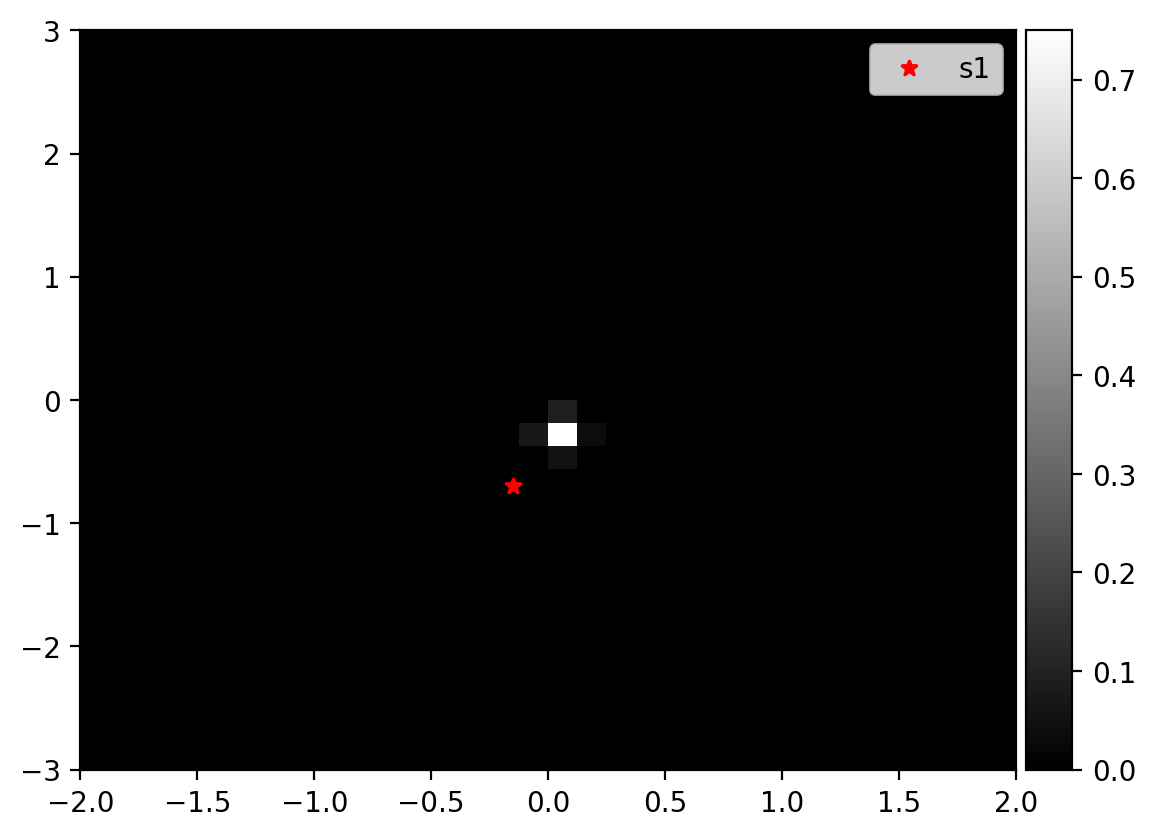

In [9]:
# explore predecessor distribution
s1 = [-0.15, -0.7]
a_i = 2
s1_i = index_s_from_s(s1)
print('sum over all preceding states', p_backward[a_i, :, s1_i].sum())

def show_p_s(p_s, ax=None, cmap='gray'):
  if ax is not None:
    plt.sca(ax)
  else:
    ax = plt.gca()
  
  im = plt.imshow(np.flip(p_s.reshape(n_v, -1), axis=0), cmap=cmap, extent=bounds_x.tolist() + bounds_v.tolist(), aspect='auto')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im, cax=cax)

plt.plot([s1[0]], [s1[1]], 'r*', label='s1', zorder=1)
plt.legend()
show_p_s(p_backward[a_i, :, s1_i])



In [10]:
# possible smoothing of the "pullback" probability
def smooth_transitions(p_pullback):
  p_pullback = np.array(p_pullback, copy=True)
  kernel = np.array([.25, 0.5, 0.25]).reshape((-1,1))
  show_image = True

  for a_i in range(aa.shape[0]):
    for s1 in range(n_s):

      # smooth s1
      p = convolve(p_pullback[a_i, :, s1].reshape(n_v, -1), kernel, mode='same')
      p = convolve(p, kernel.T, mode='same')
      if show_image and p.sum() > 0 and (np.random.uniform() < 0.01):
        fig, ax = plt.subplots(1, 3, figsize=(3*6, 8))
        plt.sca(ax[0])
        show_p_s(p_pullback[a_i, :, s1])
        plt.sca(ax[1])         
        show_p_s(p.reshape(-1))
        plt.sca(ax[2])
        show_p_s(p.reshape(-1) - p_pullback[a_i, :, s1], cmap='viridis')
        show_image=False

      p_pullback[a_i, :, s1] = p.reshape(-1)

  p_pullback = normalize(p_pullback)

  return p_pullback

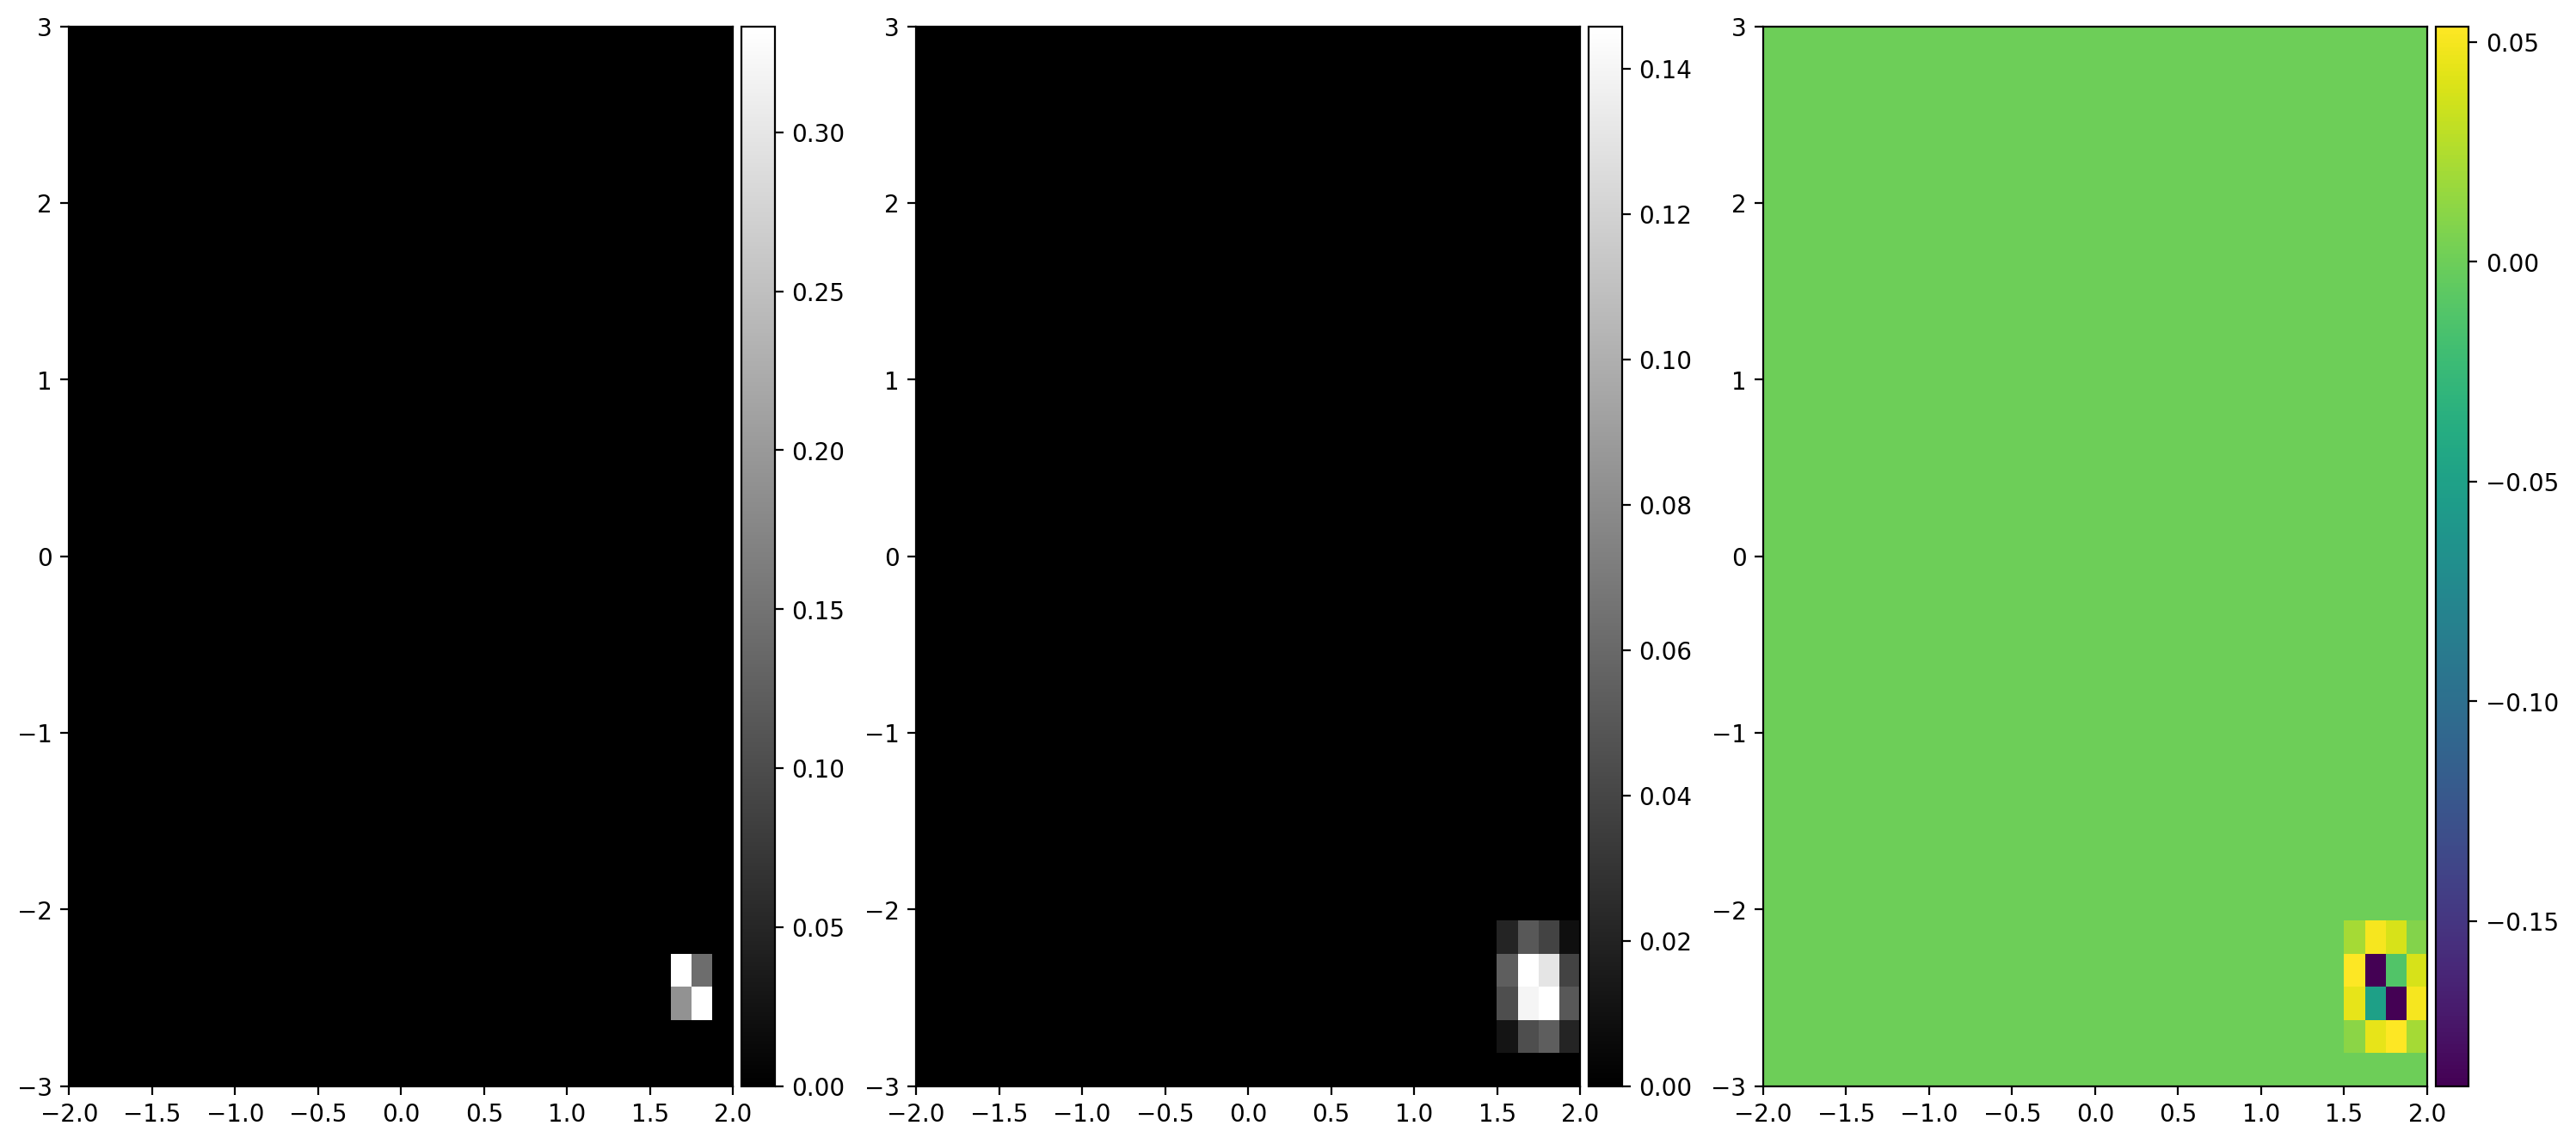

In [11]:
p_smoothed = smooth_transitions(p_backward)
p_smoothed = normalize(p_smoothed)

1.0000000000000002


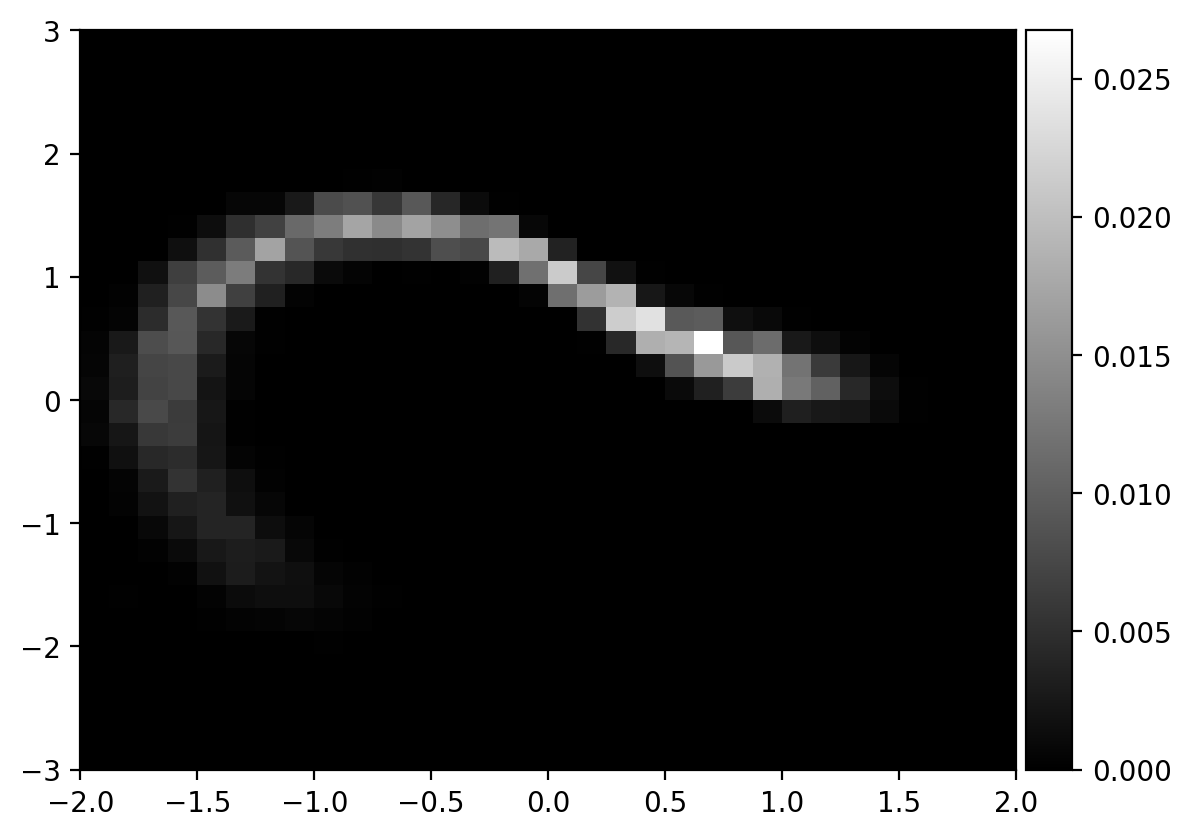

In [12]:
# simulate multiple-steps belief updating backwards in time
s1 = np.array([1,0])
i_s1 = index_s_from_s(s1)
b = np.zeros(n_s)
b[i_s1] = 1.
a_i = 2

p_transition = [p_smoothed, p_backward][1][a_i]

#p = p_s0_given_a_s1[i_s1]

B = np.copy(p_transition)
for i in range(8):
    B = np.dot(p_transition, B)
    B = normalize(B)
    
b = np.dot(B, b)
print(b.sum())
show_p_s(b)

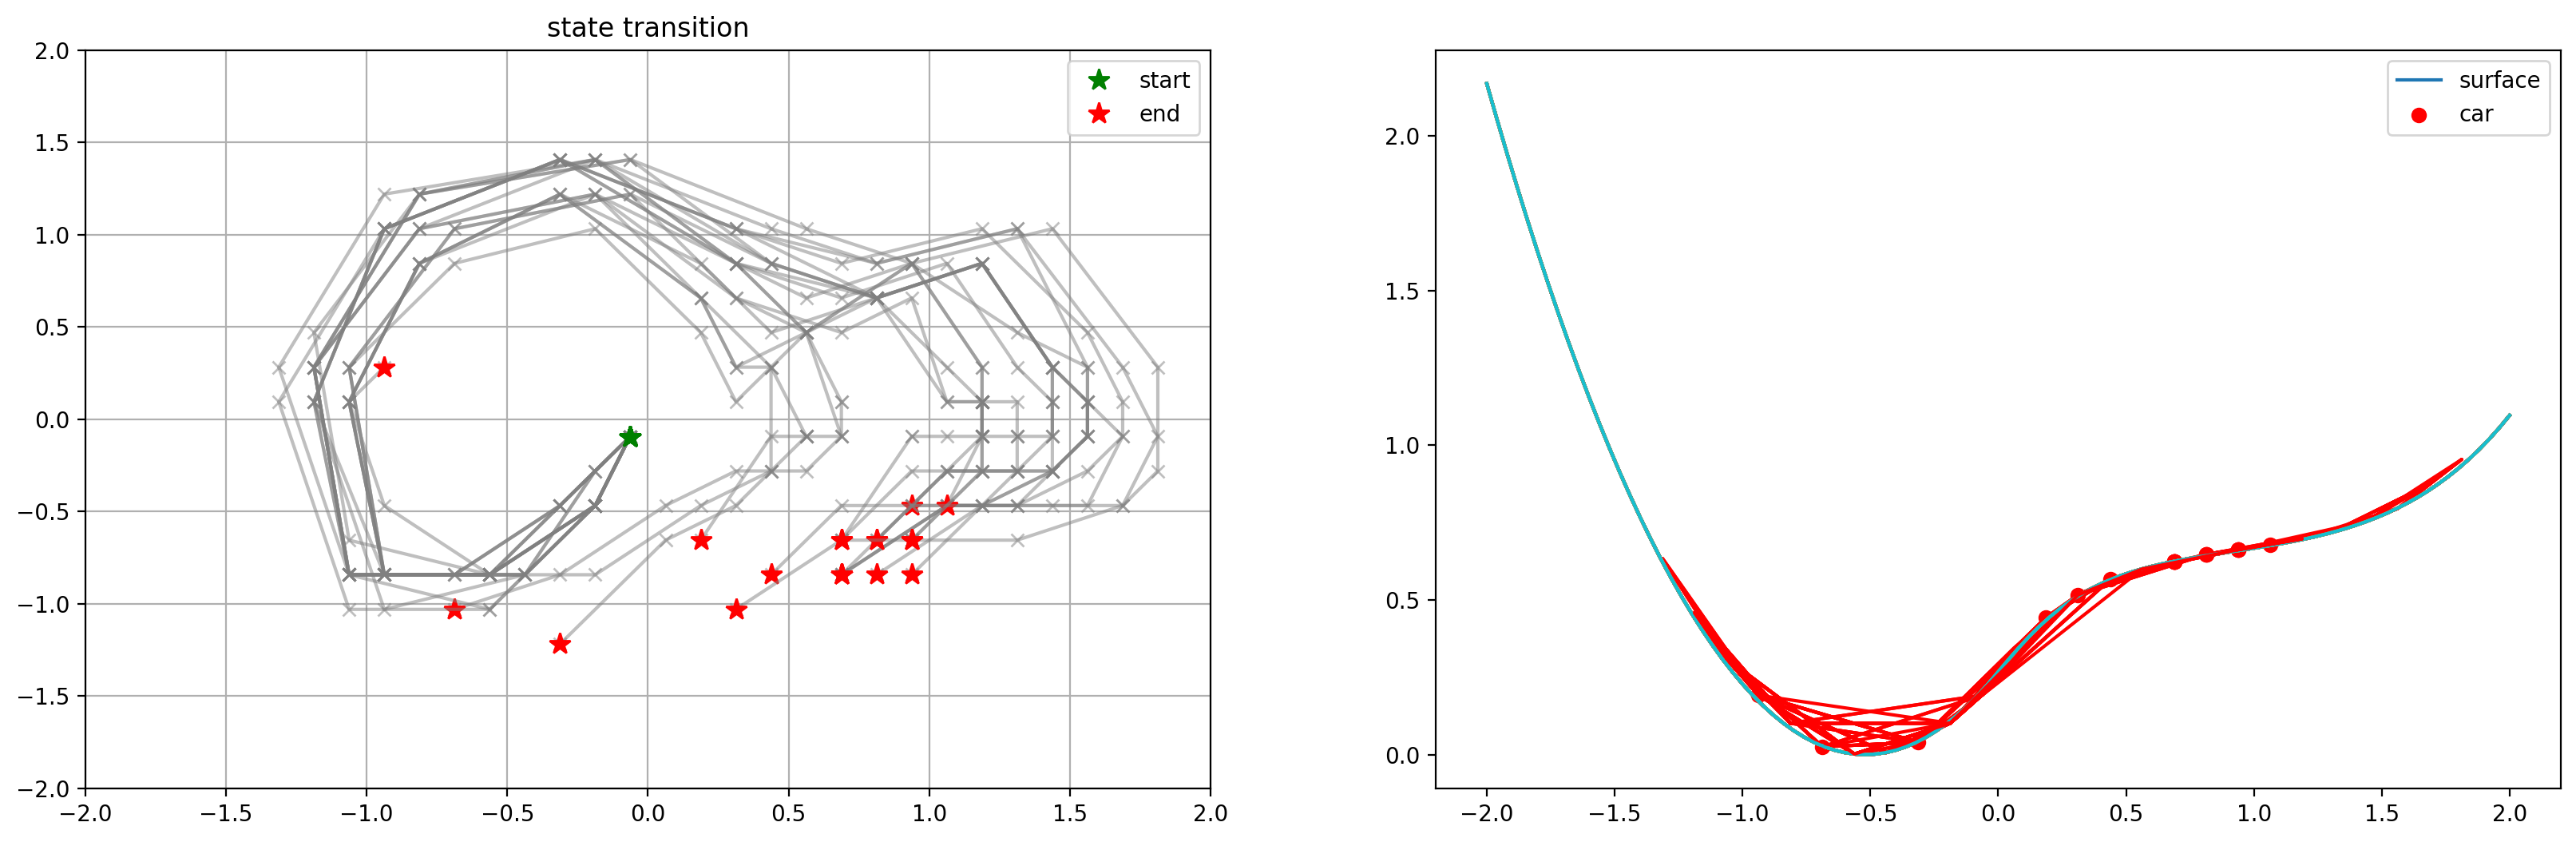

In [13]:
# sample forward
s0 = [-0.06451613, -0.09677419]
aa_fig4 = [4, 4, 3, 2, 2, 1, 1, 2, 3, 3, 3, 1, 2, 1, 2] 
        #, 4, 4, 3, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 1, 2]
aa_fig5 = [2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1] 
        #[2, 1, 1, 3, 3, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 1]
aa_i = aa_fig5

# sample forward dynamics
p_transition = [p_smoothed, p_backward][1]
p_forward = normalize(np.array(p_transition), mode='row')

fig, ax = plt.subplots(1, 2, figsize=(2*10, 6))

for i in range(20):
  ss = [s0]
  s_i = index_s_from_s(s0)
  for a_i in aa_i:
    s_i = np.random.choice(n_s, p=p_forward[a_i, s_i,:])
    ss.append(s_from_index_s(s_i))

  plot_trajectory(ss, ax=ax, legend=i==0, color='gray', alpha=0.5)

# Agency-based Optimisation

## Exact inference of the joint (max-sum algorithm)

In [14]:
T = 16 # planning horizon

def slog(x):
  # save log
  sx = np.maximum(x, 1e-6)
  return np.log(sx/sx.sum())

# 1. compute all priors
ln_pa = slog(1/n_a)
prior_s0 = np.eye(n_s)[index_s_from_s([0,0])]
ln_p0 = slog(prior_s0)
prior_sT = np.eye(n_s)[index_s_from_s([1,0])]
ln_pT = slog(prior_sT)
ln_p = slog(p_backward)

msg_s_right = np.zeros((T, n_s))
msg_s_right[-1] = ln_pT
backtrack_a = np.zeros((T, n_s), dtype=int)
backtrack_s = np.zeros((T, n_s), dtype=int)

# forward pass
for t in reversed(range(T-1)):
  arg = ln_p + msg_s_right[t+1] + ln_pa
  # take max over action only
  max_a = np.max(arg, axis=0)
  # identify next state associated with the maximum for each s0
  argmax_s1 = np.argmax(max_a, axis=1) # backtracking s1
  # take max over next state only
  max_s1 = np.max(arg, axis=2)
  # identify action associated with the maximum for each s0
  argmax_a = np.argmax(max_s1, axis=0) # backtracking a
  # take max over both state and action
  max_a_s1 = np.max(max_a, axis=1) # outgoing message
  # debug only: identify max s0
  argmax_s0 = np.argmax(max_a_s1)
  
  msg_s_right[t] = max_a_s1
  backtrack_a[t] = argmax_a
  backtrack_s[t] = argmax_s1

  print('t', t, 
        's0', s_from_index_s(argmax_s0), 
        'a', aa[argmax_a[argmax_s0]], 
        's1', s_from_index_s(argmax_s1[argmax_s0]), 
        'message', max_a_s1[argmax_s0], 
        'argument', arg[argmax_a[argmax_s0], argmax_s0, argmax_s1[argmax_s0]], 
        'validation', arg.max())

# backtracking
s0 = [0, 0]# initial state
s0_i = index_s_from_s(s0) # index of initial state
eye_s = np.eye(n_s)
eye_a = np.eye(n_a)

ss_i = [s0_i]
print(s_from_index_s(ss_i[-1]))
aa_i = [0]
for t in range(T-1):
  a_next = backtrack_a[t,ss_i[-1]]
  s_next = backtrack_s[t,ss_i[-1]]
  ss_i.append(s_next)
  aa_i.append(a_next)
  print('action', a_next, 'next state', s_from_index_s(s_next))
  
bb_s = np.array([[eye_s[s_i] for s_i in ss_i]])
bb_a = np.array([[eye_a[a_i] for a_i in aa_i]])

t 14 s0 [1.0625, -0.46875] a 1 s1 [0.9375, -0.09375] message -8.696250648549832 argument -8.696250648549832 validation -8.696250648549832
t 13 s0 [1.1875, 0.09375] a -2 s1 [1.0625, -0.46875] message -17.32407665672104 argument -17.32407665672104 validation -17.32407665672104
t 12 s0 [1.9375, -1.21875] a 1 s1 [1.4375, -1.03125] message -25.980976342524936 argument -25.980976342524936 validation -25.980976342524936
t 11 s0 [1.9375, -0.46875] a 1 s1 [1.8125, -0.46875] message -34.615795386187116 argument -34.615795386187116 validation -34.615795386187116
t 10 s0 [1.9375, 0.09375] a 0 s1 [1.9375, -0.46875] message -42.91414219322808 argument -42.91414219322808 validation -42.91414219322808
t 9 s0 [1.9375, -0.28125] a 2 s1 [1.9375, -0.28125] message -51.33311698805766 argument -51.33311698805766 validation -51.33311698805766
t 8 s0 [1.9375, -0.28125] a 2 s1 [1.9375, -0.28125] message -59.631463795098625 argument -59.631463795098625 validation -59.631463795098625
t 7 s0 [1.9375, -0.28125] a 

## Explore inference result

In [15]:
def show_inference_result(bb_a, bb_s):
  t=1
  n_samples = 20# sample tranjectories from beliefs
  n_rows, n_cols = 4, 2
  p_forward = normalize(p_backward, mode='rows')

  fig, ax = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))

  # explore actions
  # show belief over sequence of actions at convergence
  cax = ax[0][0]
  plt.sca(cax)
  plt.imshow(bb_a[-1].T, cmap='gray', aspect='auto') 
  cax.set_title('belief over actions across future timesteps');

  # show convergence of belief over actions at one timestep
  cax = ax[0][1]
  plt.sca(cax)
  for a_i in range(n_a):
      plt.plot(np.array(bb_a)[:,t,a_i], label=f'a_{t}={[-2,-1,0,1,2][a_i]}')
  cax.set_title('optimization of belief over next action');
  plt.xlabel('optimisation timestep')
  plt.ylabel('p(a_next)')
  plt.legend()

  # explore states
  # show belief over sequence of states at convergence
  cax = ax[1][0]
  plt.sca(cax)
  plt.imshow(np.array(bb_s)[-1,:,:].T, aspect='auto', interpolation='nearest')
  cax.set_title('belief over states across future timesteps');

  # show convergence of belief over states at one timestep
  cax = ax[1][1]
  plt.sca(cax)
  plt.imshow(np.array(bb_s)[:,t, :].T, aspect='auto', interpolation=None)
  cax.set_title('optimisation of belief over next state');

  # illustrate sequence of most likely states in phase space
  # sample trajectories from belief over future states
  cax=ax[2][0]
  for i in range(n_samples):
    ss = np.array([s_from_index_s(np.random.choice(range(n_s), p=np.array(bb_s)[-1,t,:])) for t in range(T)])
    plot_trajectory(ss, ax=[ax[2][0], ax[2][1]], legend=i==0, color='gray', alpha=0.5)
  cax.set_title('sample trajectories from belief over future states');

  # sample trajectories from belief over future actions
  cax=ax[3][0]
  for i in range(n_samples):
    s_i = index_s_from_s([0,0])
    ss = [s_from_index_s(s_i)]

    for t in range(1, T):
      a_i = np.random.choice(range(n_a), p=bb_a[-1][t])
      #_i = np.random.choice(range(n_a))
      p_s_i = p_forward[a_i,s_i,:]
      s_i = np.random.choice(n_s, p=p_s_i)
      ss.append(s_from_index_s(s_i))

    plot_trajectory(ss, ax=[ax[3][0], ax[3][1]], legend=i==0, color='gray', alpha=0.5)

  cax.set_title('sample trajectories from belief over future actions');

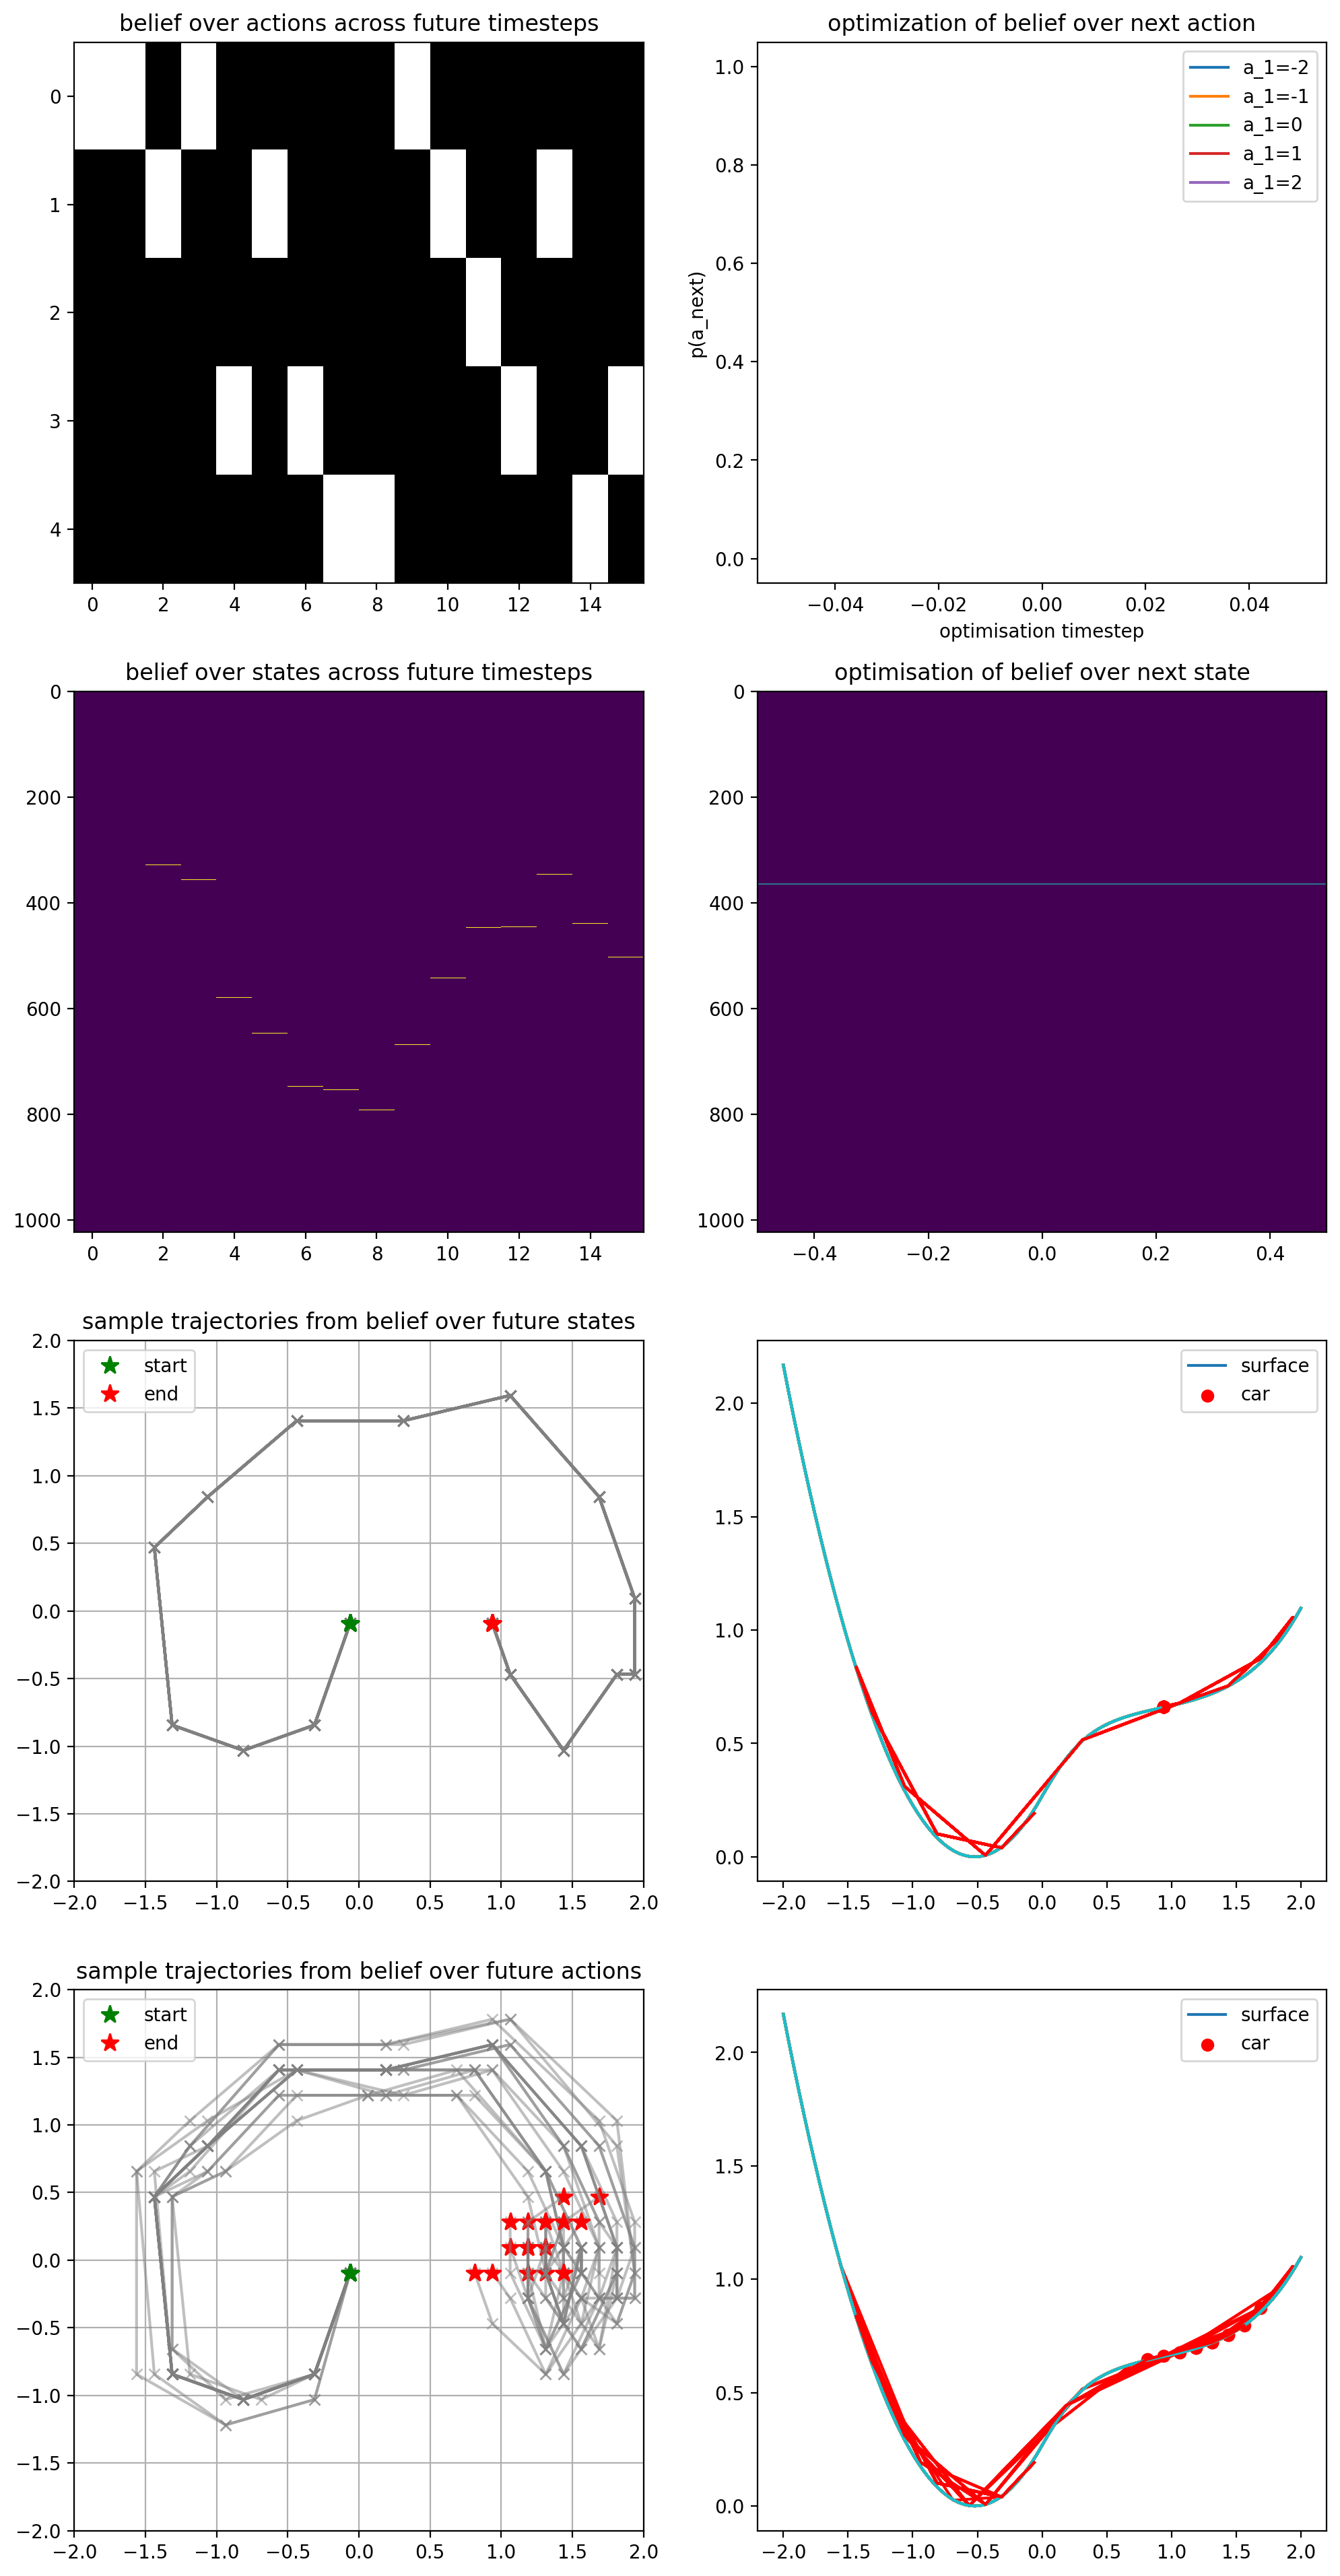

In [16]:
show_inference_result(bb_a, bb_s)

## Variational Approximation

In [17]:
n_s # number of states
n_a # number of actions

s0 = [0, 0]# initial state
s0_i = index_s_from_s(s0) # index of initial state
p_s0 = np.zeros(n_s)
p_s0[s0_i] = 1

sT = [1, 0] # target final hidden state
sT_i = index_s_from_s(sT) # index of target state
p_sT = np.zeros(n_s)
p_sT[sT_i] = 1 # prior over final hidden state - c

# A: identity
# priors (c, d in Eq. 12)
p_a = np.ones(n_a)/n_a# prior belief/ cost over control states - d
p_s = np.ones(n_s)/n_s# prior belief/ cost over intermediate future states ????

# initial beliefs: initialize them at random???
b_a = np.tile(p_a, (T, 1)) # u_t
b_s = np.tile(p_s, (T, 1)) # beliefs over states across timesteps (t, s): alpha_t
b_s[-1,:] = p_sT # set belief of final state to prior
b_s[0,:] = p_s0

# log action prior
log_p_a = np.log(p_a)

# Equation 15

# variational energy I of state s_t is expectation over terms
# 1) ln P(o_t|s_t), for executed timesteps t
#    - in our case, this is 1 because the environment is fully observed.
#    - can be pulled out of the expectation
# 2) ln P(s_t|s_t+1, u_t+1)
#    - expectation over both s_t+1 and u_t+1
#    - for each possible action: probability of taking that action * action-dependent transition p(s_t|s_t+1), with belief over s_t+1
# 3) Expectation over Q(s_t-1) and Q(u_t) ln P(s_t-1|s_t, u_t)
#    - expectation over s_t-1 and u_t
#    - for each possible action: probability of taking that action * action_dependent transition p(s_t-1|s_t) with belief over s_t-1
def variational_energy_s(t, b_a, b_s, p_backward):
  # is observed? add one
  b_a_next = b_a[t+1]
  b_a_now = b_a[t]
  b_s_next = b_s[t+1]
  b_s_prev = b_s[t-1]
  
  first = np.dot(b_a_next, np.dot(p_backward, b_s_next))
  #print('first', first)
  second = np.dot(b_a_now, np.dot(b_s_prev, p_backward))
  #print('second', second)
  return np.log(np.maximum(first, 1e-6)) + np.log(np.maximum(second, 1e-6))

# variational energy I over control state u_t,i is expectation oer beliefs about
# s_t-1 and s_t
# 1) ln P(s_t-1|s_t, u_t)
#    - expectation over s_t-1 and s_t, fixed u_t
# 2) ln P(u_t)
#    - can be pulled out of expectation
def variational_energy_a_i(t, i, b_s, p_backward, log_p_a):
  b_s_now = b_s[t]
  b_s_prev = b_s[t-1]
  first = np.dot(b_s_prev, np.dot(p_backward[i,:,:], b_s_now))
  second = log_p_a[i]
  return np.log(first) + second

def agency_based_selection(b_s, b_a, p_backward, debug=False):
  k = 0
  T = b_s.shape[0]
  n_steps = 32 # optimization ('until convergence')
  bb_s = [np.copy(b_s)] # tracking progress
  bb_a = [np.copy(b_a)] # tracking progress

  #for k in range(T-1):
  #print('k', k)
  for _ in tqdm(range(n_steps)): # repeat until convergence
    
    t = T-1
    log_i_a = np.array([variational_energy_a_i(t, i, b_s, p_backward, log_p_a) for i in range(n_a)])
    b_a[t] = np.exp(log_i_a)
    b_a[t] = b_a[t]/b_a[t].sum()
    
    for t in reversed(range(k+1, T-1, 1)):
      log_i_s = variational_energy_s(t, b_a, b_s, p_backward)
      log_i_a = np.array([variational_energy_a_i(t, i, b_s, p_backward, log_p_a) for i in range(n_a)])
      
      b_a[t] = np.exp(log_i_a)
      b_a[t] = b_a[t]/b_a[t].sum()
      
      b_s[t] = np.exp(log_i_s)
      b_s[t] = b_s[t]/b_s[t].sum()
      

    bb_a.append(np.copy(b_a))
    bb_s.append(np.copy(b_s))

  if debug == True:
    return bb_a[-1][1], bb_a, bb_s
  
  return bb_a[-1][1]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.12it/s]


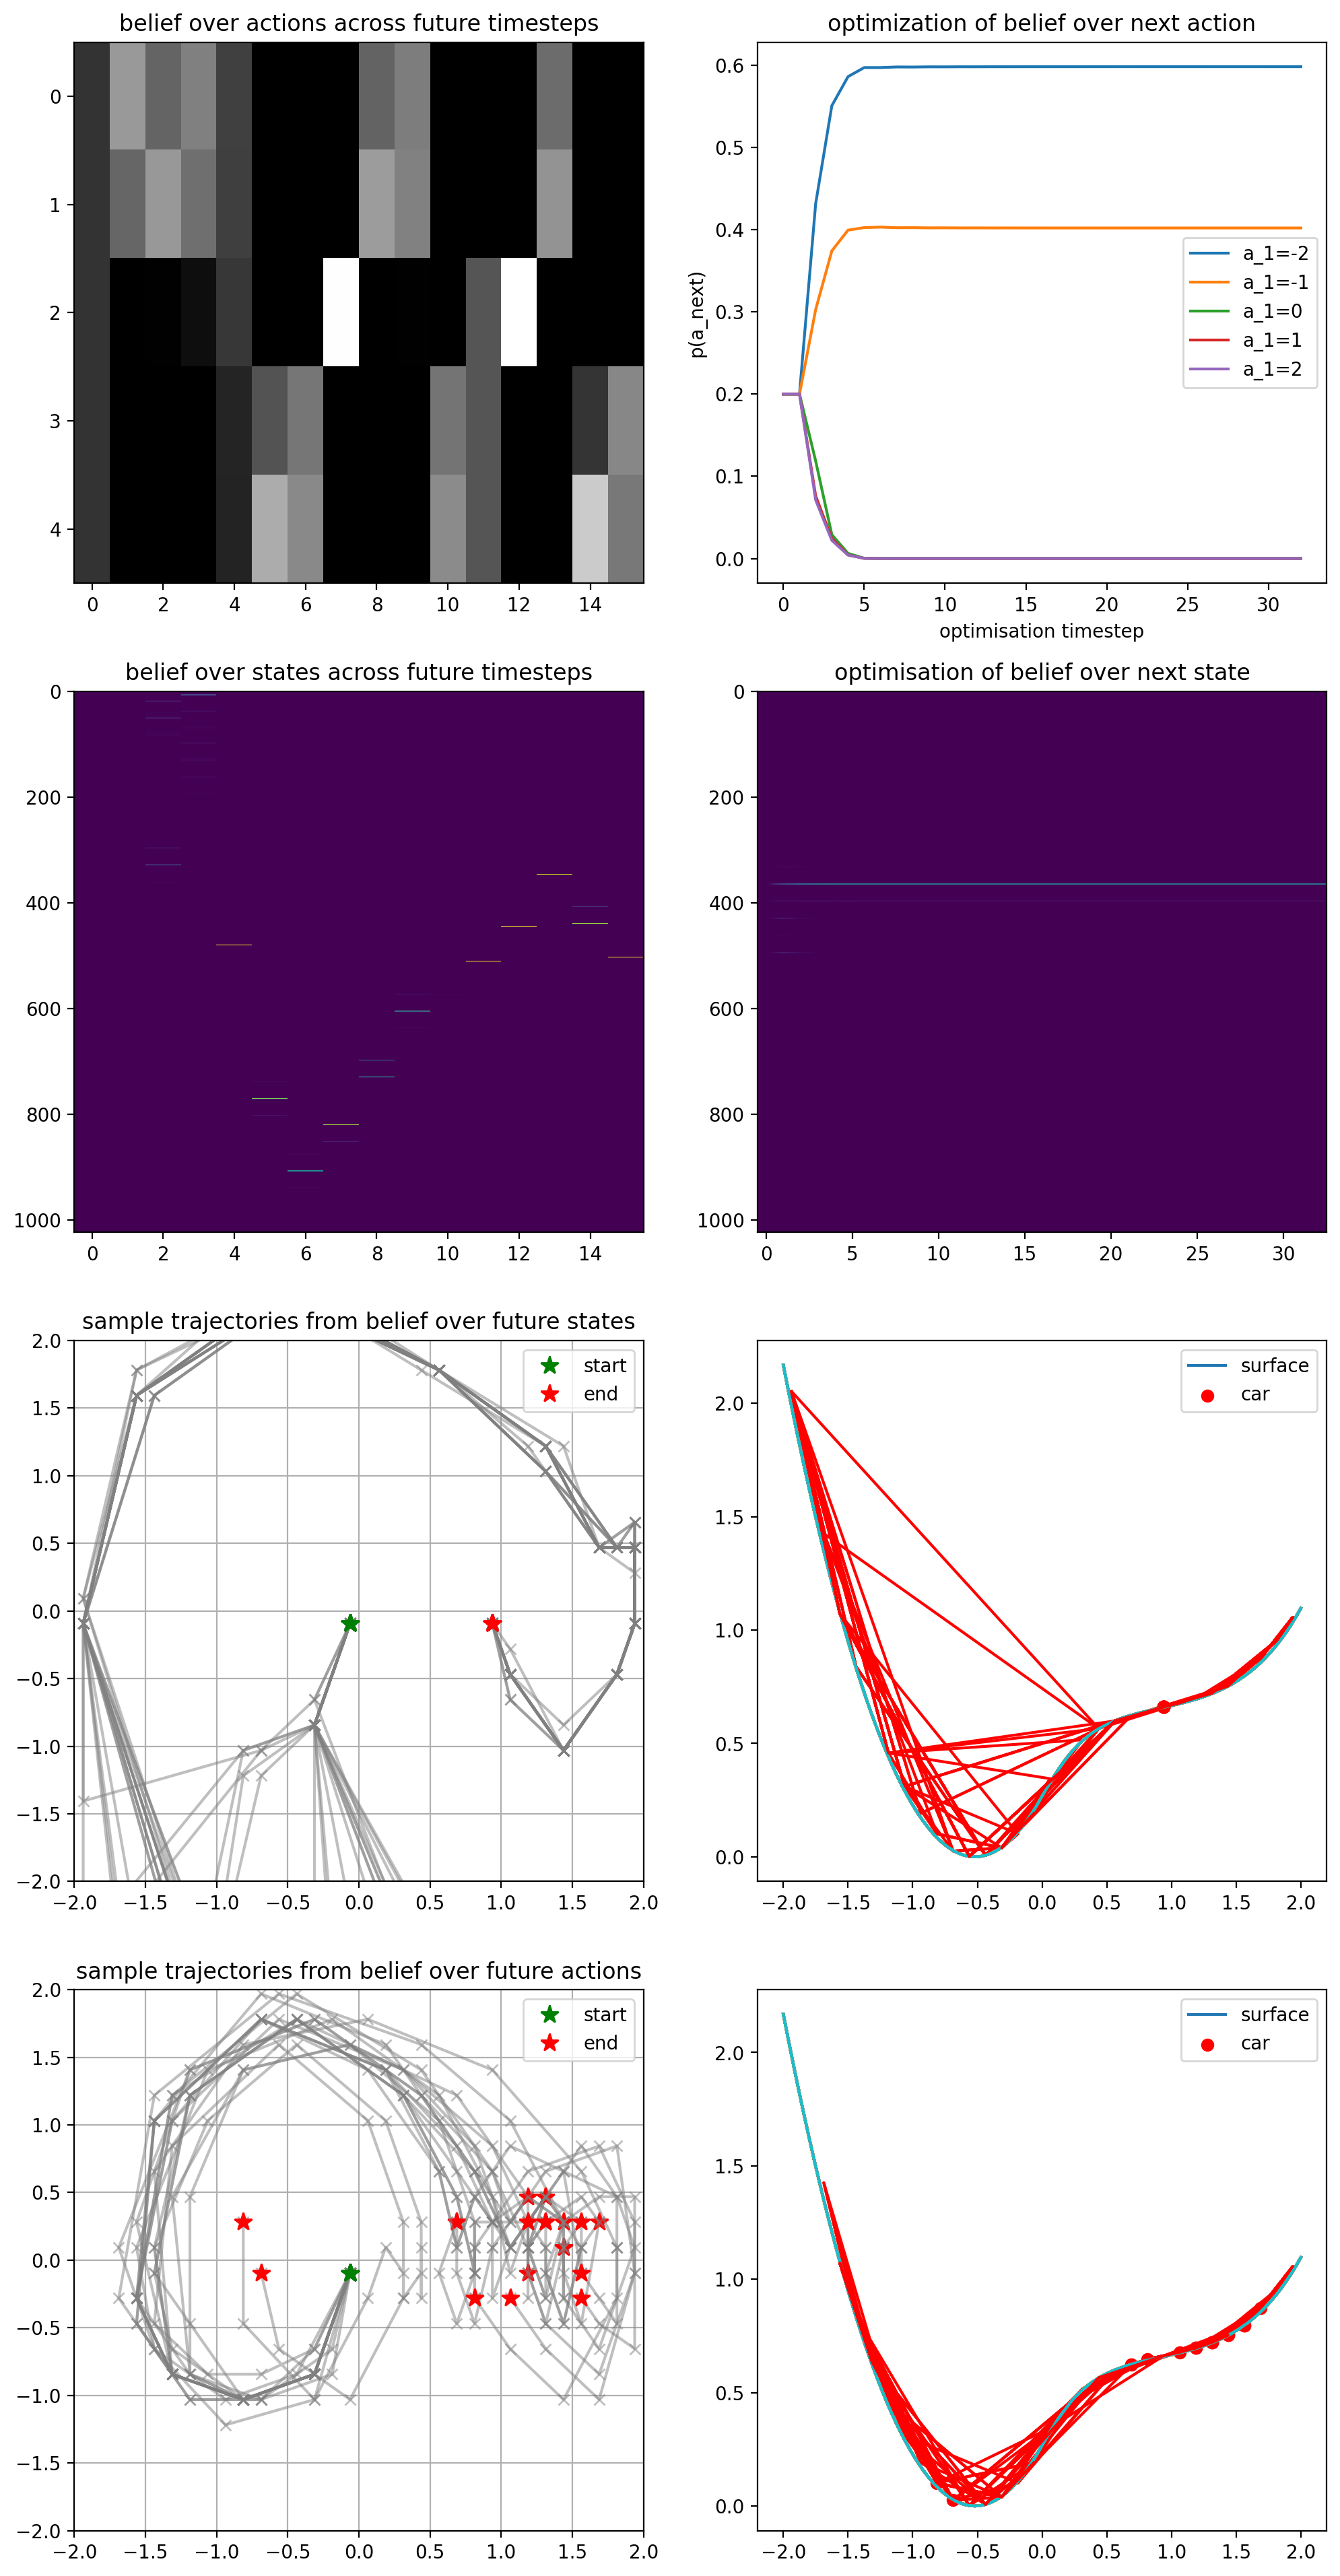

In [18]:
p_a_next, bb_a, bb_s = agency_based_selection(b_s, b_a, [p_smoothed, p_backward][1], debug=True)
show_inference_result(bb_a, bb_s)

## Exact inference of the marginals

(16, 5) [0.2 0.2 0.2 0.2 0.2]
right to left 14 [0. 0. 0. ... 0. 0. 0.] sum: 1.155403048855849
right to left 13 [0. 0. 0. ... 0. 0. 0.] sum: 1.31648637180758
right to left 12 [0. 0. 0. ... 0. 0. 0.] sum: 1.4371371508236914
right to left 11 [0.         0.         0.         ... 0.00053424 0.00053424 0.00053424] sum: 1.537432303768676
right to left 10 [0.         0.         0.         ... 0.00810027 0.00810027 0.00810027] sum: 2.180567957865572
right to left 9 [0.00036627 0.00036627 0.00036627 ... 0.00752552 0.00752552 0.00752552] sum: 2.712471446707628
right to left 8 [0.00408755 0.00408755 0.00408755 ... 0.00546372 0.00546372 0.00546372] sum: 3.2570263535594
right to left 7 [0.00393507 0.00393507 0.00393507 ... 0.00416805 0.00416805 0.00416805] sum: 3.5424008975592844
right to left 6 [0.00331952 0.00331952 0.00331952 ... 0.00323736 0.00323736 0.00323736] sum: 3.581077050291422
right to left 5 [0.00387038 0.00387038 0.00387038 ... 0.00251542 0.00251542 0.00251542] sum: 3.4877507251000024

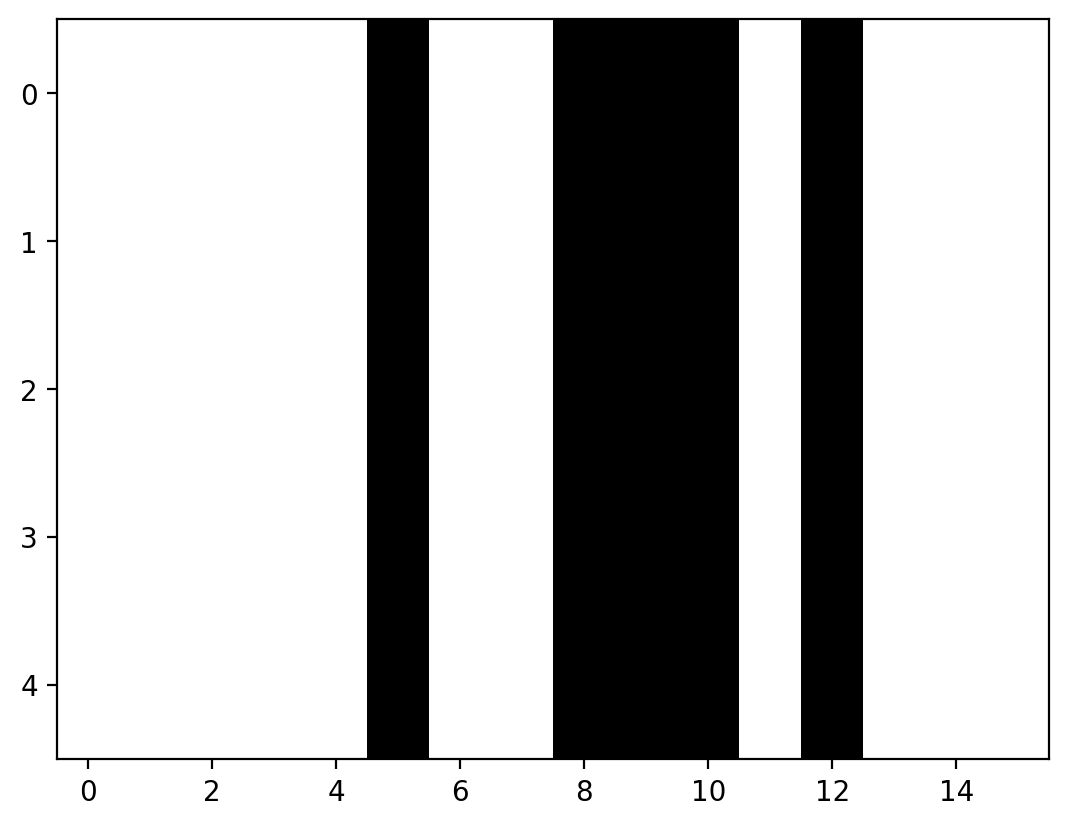

In [19]:
# exact inference: sum-product algorithm

# 1. compute all priors
prior_a = np.ones((T, n_a))/n_a
prior_s0 = np.zeros(n_s)
prior_s0[index_s_from_s([0,0])] = 1
prior_sT = np.zeros(n_s)
prior_sT[index_s_from_s([1,0])] = 1
print(prior_a.shape, prior_a[0])
#plt.imshow(prior_a.T, cmap='gray', aspect='auto', vmin=0, vmax=1) # shows black
#show_p_s(prior_sT)

# 2. right to left pass
msg_s_right = np.zeros((T, n_s))
msg_s_right[-1] = prior_sT
for t in reversed(range(T-1)):
  msg_s_right[t] = np.dot(prior_a[t+1], np.dot(p_backward, msg_s_right[t+1]))
  print('right to left', t, msg_s_right[t], 'sum:', msg_s_right[t].sum())
  
# 3. left to right pass
msg_s_left = np.zeros_like(msg_s_right)
msg_s_left[0] = prior_s0
for t in range(1, T):
  msg_s_left[t] = np.dot(prior_a[t], np.array([np.dot(msg_s_left[t-1], p_backward[a_i]) for a_i in range(n_a)]))
  print('left to right', t, msg_s_left[t], 'sum:', msg_s_left[t].sum())
   
# 4. compute state marginals
b_s = msg_s_left * msg_s_right
b_s = normalize(b_s, mode='rows')
    
# 5. compute action marginals
b_a = np.copy(prior_a)
for t in range(1, T):
  b_a[t] = np.dot(prior_a[t], np.array([np.dot(msg_s_left[t-1], np.dot(p_backward[a_i], msg_s_right[t])) for a_i in range(n_a)]))
  print('action', t, b_a[t])

b_a = normalize(b_a, mode='rows')
  
bb_a = [b_a]
bb_s = [b_s]

plt.imshow(bb_a[-1].T, cmap='gray', aspect='auto') 

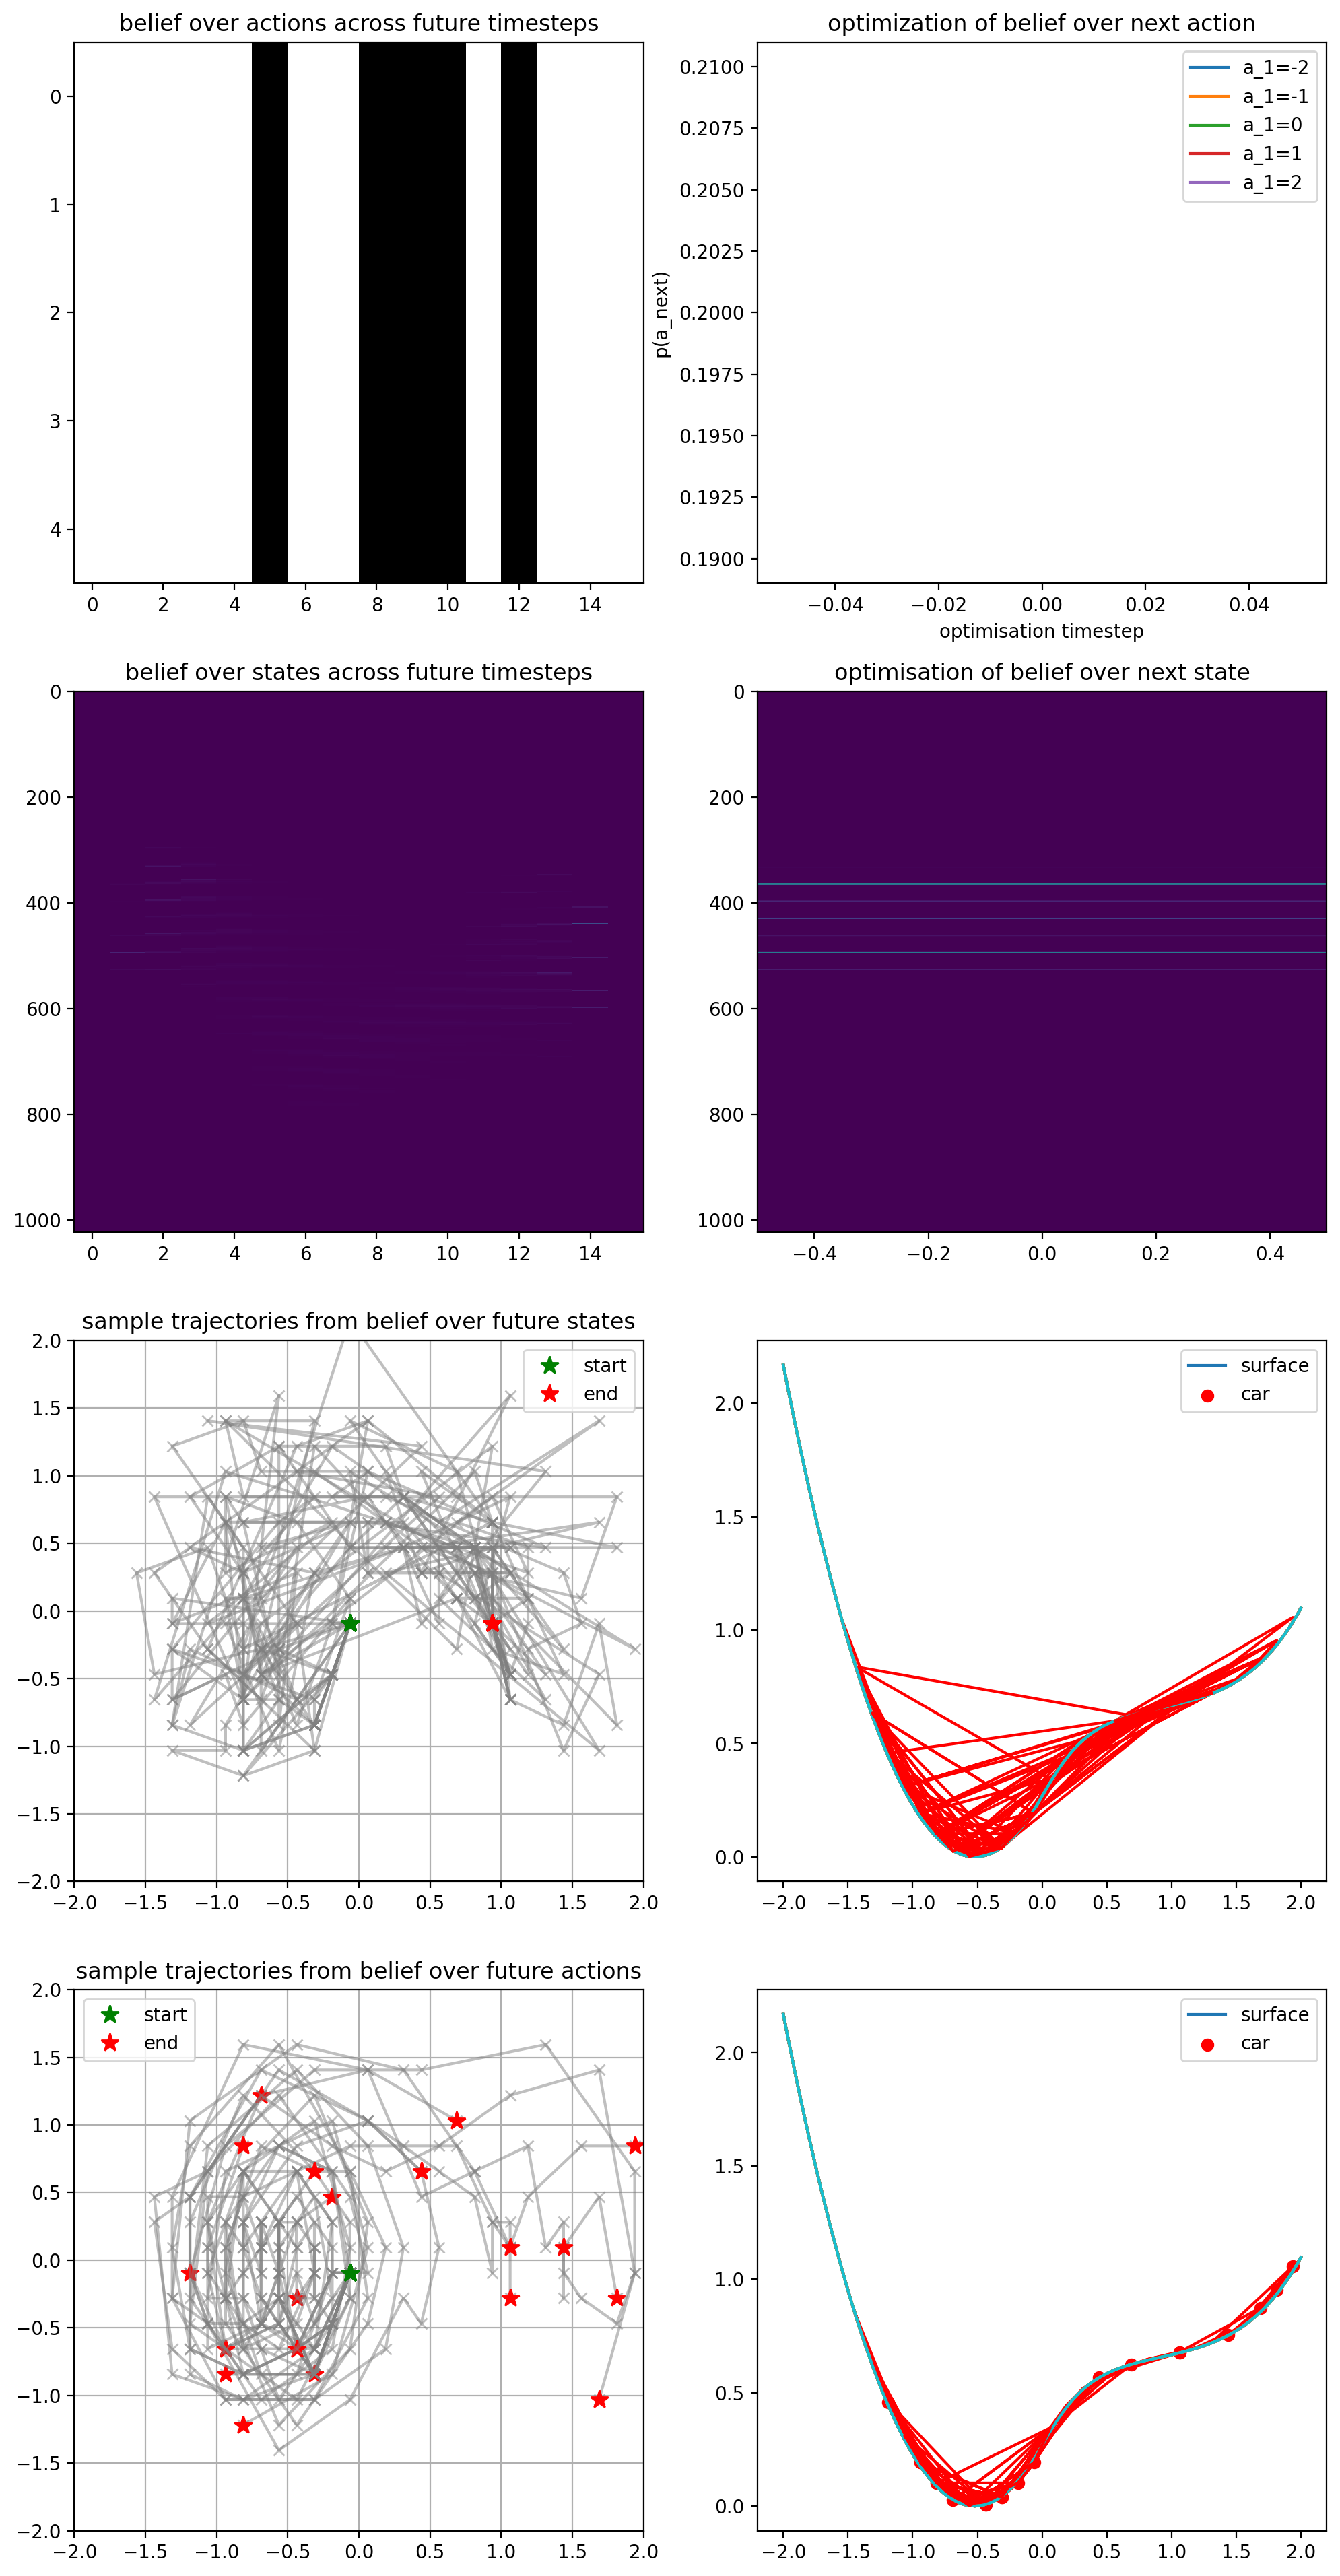

In [20]:
show_inference_result(bb_a, bb_s)